In [5]:
import polars as pl
import pandas as pd
from sklearn.utils import shuffle

In [6]:
# Function to process and merge data for a given split
def process_split(split_number):
    combined_df = pd.DataFrame()
    for i in range(1, 201):
        # Read data from both sources
        temp_df = pd.read_csv(f"../../Data/Neo_Feat/Split{split_number}/chunk_{i}.csv")
        temp_df_2 = pd.read_csv(f"../../Data/gpt2-large-feature/Split{split_number}/chunk_{i}.csv")

        # Merge the dataframes
        result = pd.merge(temp_df, temp_df_2, on=[
            'text', 'source', 'prompt_id', 'text_length', 
            'word_count', 'label'], how='inner')
        
        # Concatenate results
        combined_df = pd.concat([combined_df, result], axis=0)
    
    return combined_df

# Process each split
df_1 = process_split(1)
df_2 = process_split(2)
df_3 = process_split(3)
df_4 = process_split(4)

In [7]:
df = pd.concat([df_1,df_2,df_3,df_4], axis = 0)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 394350 entries, 0 to 308
Data columns (total 28 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   text                       394350 non-null  object 
 1   source                     394350 non-null  object 
 2   prompt_id                  394350 non-null  int64  
 3   text_length                394350 non-null  int64  
 4   word_count                 394350 non-null  int64  
 5   label                      394350 non-null  int64  
 6   gpt-neo-125m-text_ppl      394350 non-null  float64
 7   gpt-neo-125m-max_sent_ppl  394350 non-null  float64
 8   gpt-neo-125m-sent_ppl_avg  394350 non-null  float64
 9   gpt-neo-125m-sent_ppl_std  394350 non-null  float64
 10  gpt-neo-125m-max_step_ppl  394350 non-null  float64
 11  gpt-neo-125m-step_ppl_avg  394350 non-null  float64
 12  gpt-neo-125m-step_ppl_std  394350 non-null  float64
 13  gpt-neo-125m-rank_0        394350 non

In [ ]:
# Assuming df is your dataframe with columns: text, source, label
# Step 1: Split into human and AI subsets
human_data = df[df['label'] == 0]
ai_data = df[df['label'] == 1]

# Step 2: Randomly sample 5000 rows for human data
human_sample = human_data.sample(n=5000)

# Step 3: Sample 5000 rows for AI data, fairly across sources
ai_sources = ai_data['source'].value_counts(normalize=True)  # Proportions of each source
ai_sampled_data = []

for source, proportion in ai_sources.items():
    n_samples = int(proportion * 5000)  # Determine number of samples for this source
    sampled_source = ai_data[ai_data['source'] == source].sample(n=n_samples)
    ai_sampled_data.append(sampled_source)

# Combine all AI samples into a single dataframe
ai_sample = pd.concat(ai_sampled_data)


if(len(ai_sample) < 5000):
    sampled_data_appendix = ai_data.sample(n=5000- len(ai_sample), replace=False)
    ai_sample = pd.concat([ai_sample, sampled_data_appendix], axis = 0)

# Step 4: Combine human and AI samples, then shuffle
final_sample = pd.concat([human_sample, ai_sample])
final_sample = shuffle(final_sample).reset_index(drop=True)

# final_sample now contains the desired balanced dataset
print(final_sample.head())


                                                text          source  \
0  \nThe relationship between economic growth and...  Psyfighter-13B   
1  Subway Restaurant Service Marketing Term Paper...           Human   
2  Jane Eyre by Charlotte Bronte Research Paper\n...           Human   
3  The former Liverpool, Swansea City, Reading an...           Human   
4  Xiaomi has launched a pair of smart glasses. T...         OPT-13B   

   prompt_id  text_length  word_count  label  gpt-neo-125m-text_ppl  \
0       4399         5227         718      1               7.276393   
1          0        28010        4640      0              29.863869   
2          0         3682         645      0              17.757170   
3          0         3712         627      0              29.349361   
4          0         1734         267      1              72.466469   

   gpt-neo-125m-max_sent_ppl  gpt-neo-125m-sent_ppl_avg  \
0                  16.317610                   8.023601   
1                 127.

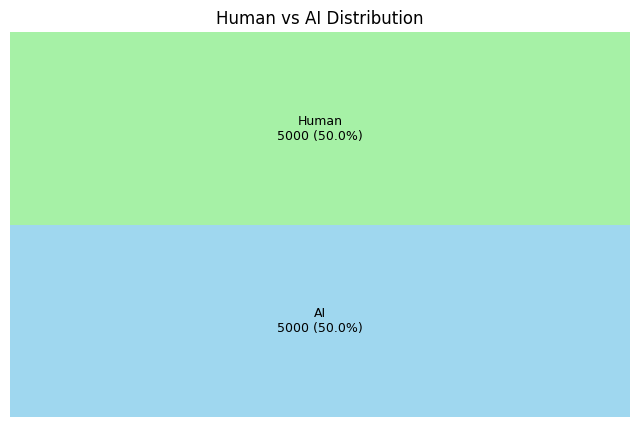

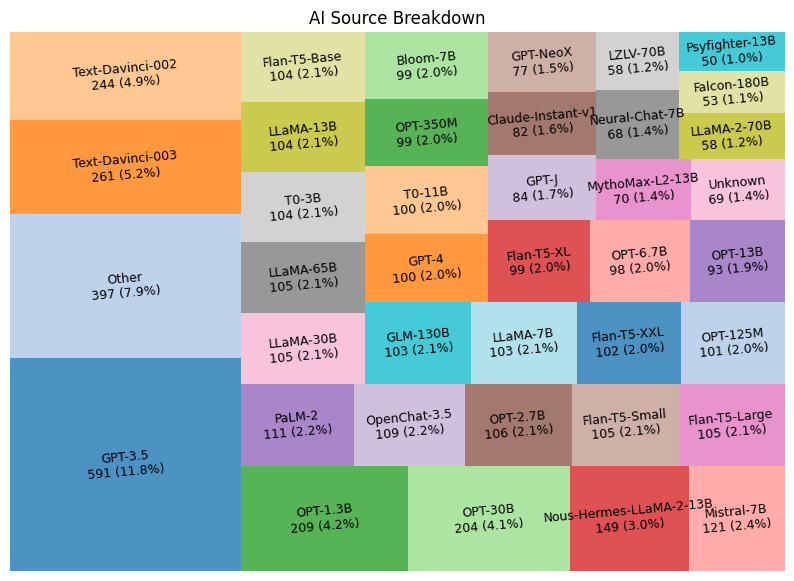

In [11]:
import matplotlib.pyplot as plt
import squarify  # For treemap

# Assuming 'final_sample' is your DataFrame
final_sample['source_category'] = final_sample['source'].apply(lambda x: 'Human' if x.lower() == 'human' else 'AI')

source_distribution = final_sample['source_category'].value_counts()

# Calculate percentages for Human vs AI
total_count = source_distribution.sum()
source_distribution_percentage = (source_distribution / total_count) * 100

# Plot the first treemap (Human vs AI distribution)

labels = [f"{key}\n{value} ({source_distribution_percentage[key]:.1f}%)" for key, value in source_distribution.items()]


# Plot the treemap for Human vs AI
plt.figure(figsize=(8, 5))
ax = squarify.plot(
    sizes=source_distribution.values,
    # label=labels,
    alpha=0.8,
    color=['skyblue', 'lightgreen']
)

for i, rect in enumerate(ax.patches):
    x = rect.get_x() + rect.get_width() / 2  # x position for label
    y = rect.get_y() + rect.get_height() / 2  # y position for label
    ax.text(x, y, labels[i], ha='center', va='center', fontsize=9, color='black', rotation=0)

plt.title('Human vs AI Distribution')
plt.axis('off')
plt.show()
###########################################################################################
# For the AI breakdown, categorize AI sources with less than 1700 counts as 'Other'
ai_data = final_sample[final_sample['source_category'] == 'AI']
ai_counts = ai_data['source'].value_counts().reset_index()
ai_counts.columns = ['source', 'count']
ai_counts['source'] = ai_counts.apply(lambda row: row['source'] if row['count'] >= 50 else 'Other', axis=1)
ai_counts = ai_counts.groupby('source').sum().reset_index()

# Sort AI counts in descending order
ai_counts = ai_counts.sort_values(by='count', ascending=False)

# Calculate percentages
total_count = ai_counts['count'].sum()
ai_counts['percentage'] = (ai_counts['count'] / total_count) * 100

# Create labels with counts and percentages
ai_counts['label'] = ai_counts.apply(
    lambda row: f"{row['source']}\n{row['count']} ({row['percentage']:.1f}%)", axis=1
)

# Treemap: AI Source Breakdown (sorted with counts and percentages in labels)
plt.figure(figsize=(10, 7))
ax = squarify.plot(
    sizes=ai_counts['count'],
    # label=ai_counts['label'],
    color=plt.cm.tab20.colors,
    alpha=0.8,
)

for i, rect in enumerate(ax.patches):
    x = rect.get_x() + rect.get_width() / 2  # x position for label
    y = rect.get_y() + rect.get_height() / 2  # y position for label
    ax.text(x, y, ai_counts['label'].iloc[i], ha='center', va='center', fontsize=9, rotation=5, color='black')

plt.title('AI Source Breakdown')
plt.axis('off')
plt.show()

In [26]:
train_df = df[~df.text.isin(final_sample.text)]
test_df = final_sample

In [27]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 384350 entries, 0 to 308
Data columns (total 28 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   text                       384350 non-null  object 
 1   source                     384350 non-null  object 
 2   prompt_id                  384350 non-null  int64  
 3   text_length                384350 non-null  int64  
 4   word_count                 384350 non-null  int64  
 5   label                      384350 non-null  int64  
 6   gpt-neo-125m-text_ppl      384350 non-null  float64
 7   gpt-neo-125m-max_sent_ppl  384350 non-null  float64
 8   gpt-neo-125m-sent_ppl_avg  384350 non-null  float64
 9   gpt-neo-125m-sent_ppl_std  384350 non-null  float64
 10  gpt-neo-125m-max_step_ppl  384350 non-null  float64
 11  gpt-neo-125m-step_ppl_avg  384350 non-null  float64
 12  gpt-neo-125m-step_ppl_std  384350 non-null  float64
 13  gpt-neo-125m-rank_0        384350 non

In [28]:
train_df.to_csv("Train.csv")
test_df.to_csv("Test.csv")